# CV Model Training Notebook (PyTorch)

Source code: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion() 

In [2]:
torch.cuda.is_available()

True

In [3]:
# Download the data from here and extract it to the current directory.

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

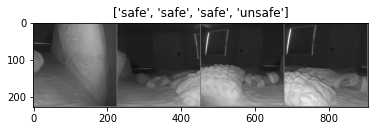

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(outputs)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/dtien/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/dtien/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8208 Acc: 0.6447
val Loss: 0.1885 Acc: 0.9318

Epoch 1/24
----------
train Loss: 0.5754 Acc: 0.7504
val Loss: 0.0168 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.5498 Acc: 0.7851
val Loss: 0.0237 Acc: 0.9864

Epoch 3/24
----------
train Loss: 0.5056 Acc: 0.8059
val Loss: 0.0100 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.4292 Acc: 0.8267
val Loss: 0.0159 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.4181 Acc: 0.8267
val Loss: 0.0189 Acc: 0.9955

Epoch 6/24
----------
train Loss: 0.3337 Acc: 0.8440
val Loss: 0.0115 Acc: 0.9955

Epoch 7/24
----------
train Loss: 0.2617 Acc: 0.8700
val Loss: 0.0059 Acc: 0.9955

Epoch 8/24
----------
train Loss: 0.2551 Acc: 0.8804
val Loss: 0.0089 Acc: 0.9955

Epoch 9/24
----------
train Loss: 0.2581 Acc: 0.8752
val Loss: 0.0077 Acc: 0.9955

Epoch 10/24
----------
train Loss: 0.2161 Acc: 0.8995
val Loss: 0.0054 Acc: 0.9955

Epoch 11/24
----------
train Loss: 0.2527 Acc: 0.8839
val Loss: 0.0059 Acc: 0.9955

Ep

tensor([[ 1.1308, -2.2165],
        [-4.5877,  2.8350],
        [-5.1310,  3.6699],
        [ 1.4673, -2.7123]], device='cuda:0')


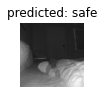

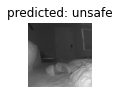

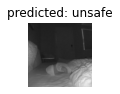

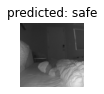

tensor([[-3.1549,  1.6645],
        [ 1.4688, -2.4239],
        [ 1.7925, -3.0995],
        [ 1.0584, -1.8416]], device='cuda:0')


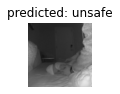

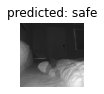

In [9]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8094 Acc: 0.5477
val Loss: 0.7051 Acc: 0.5727

Epoch 1/24
----------
train Loss: 0.7210 Acc: 0.6187
val Loss: 0.2676 Acc: 0.9591

Epoch 2/24
----------
train Loss: 0.6440 Acc: 0.6620
val Loss: 0.1950 Acc: 0.9409

Epoch 3/24
----------
train Loss: 0.6650 Acc: 0.6499
val Loss: 0.4205 Acc: 0.7955

Epoch 4/24
----------
train Loss: 0.7841 Acc: 0.6534
val Loss: 0.3059 Acc: 0.8682

Epoch 5/24
----------
train Loss: 0.7020 Acc: 0.6759
val Loss: 0.2002 Acc: 0.9364

Epoch 6/24
----------
train Loss: 0.7270 Acc: 0.6551
val Loss: 0.5052 Acc: 0.7545

Epoch 7/24
----------
train Loss: 0.5148 Acc: 0.7366
val Loss: 0.4041 Acc: 0.8091

Epoch 8/24
----------
train Loss: 0.5287 Acc: 0.7262
val Loss: 0.2089 Acc: 0.9455

Epoch 9/24
----------
train Loss: 0.5395 Acc: 0.7314
val Loss: 0.2286 Acc: 0.9364

Epoch 10/24
----------
train Loss: 0.4748 Acc: 0.7643
val Loss: 0.1586 Acc: 0.9500

Epoch 11/24
----------
train Loss: 0.5952 Acc: 0.6603
val Loss: 0.1762 Acc: 0.9500

Ep

tensor([[-2.4217,  0.8565],
        [-1.4100, -0.3498],
        [-2.3916,  1.1008],
        [-1.9212,  0.4675]], device='cuda:0')


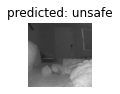

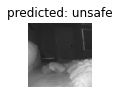

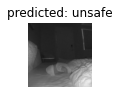

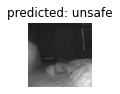

tensor([[-2.1128,  0.8997],
        [ 0.1941, -1.4568],
        [-1.9154,  0.5262],
        [ 0.3468, -1.3533]], device='cuda:0')


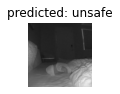

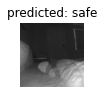

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()